Les fichiers .mat contiennent des matrices ou structures MATLAB. Dans les datasets Pavia University et Indian Pines, il y a généralement :

une matrice 3D : (hauteur, largeur, nombre de bandes spectrales) contenant les images hyperspectrales.

une matrice 2D ou 1D : les étiquettes de classes (ground truth), avec une valeur entière par pixel indiquant à quelle classe il appartient.

# 1. Manipulation des images Indian Pines

In [ ]:
import scipy.io
import numpy as np

# Chargement de Indian Pines
data = scipy.io.loadmat('Indian_pines_corrected.mat')
labels = scipy.io.loadmat('Indian_pines_gt.mat')

# Extraction des matrices
hyperspectral_data = data['indian_pines_corrected']  # shape: (145, 145, 200)
ground_truth = labels['indian_pines_gt']             # shape: (145, 145)


On peut afficher une fausse image en couleur en utilisant quelques bandes spectrales (par ex. bande 30, 50, 80).

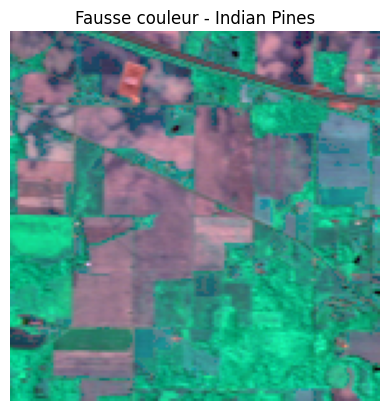

In [3]:
import matplotlib.pyplot as plt

# Normalisation
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

# Affichage RGB avec 3 bandes choisies
rgb = np.dstack([
    normalize(hyperspectral_data[:, :, 30]),
    normalize(hyperspectral_data[:, :, 50]),
    normalize(hyperspectral_data[:, :, 80]),
])

plt.imshow(rgb)
plt.title("Fausse couleur - Indian Pines")
plt.axis("off")
plt.show()


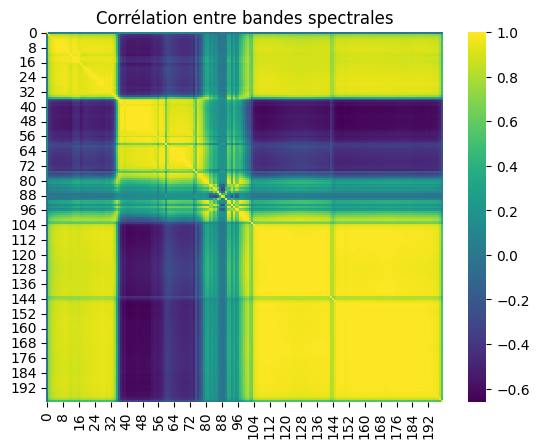

In [7]:
import numpy as np

# Données reshaped : (n_pixels, n_bandes)
reshaped = hyperspectral_data.reshape(-1, hyperspectral_data.shape[2])

# Corrélation entre les bandes
correlation_matrix = np.corrcoef(reshaped.T)

# Exemple : afficher une heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, cmap="viridis")
plt.title("Corrélation entre bandes spectrales")
plt.show()


Observation :

- L’image brute paraît terne car les longueurs d’onde ne sont pas dans le spectre visible.

- Les bandes sont fortement corrélées d'après la matrice de correlation, d’où l’intérêt d’une réduction de dimension.

L’ACP permet de réduire la dimensionnalité (par exemple de 200 bandes → 3 composantes principales).
On utilise 3 composantes car on a besoin de 3 canaux de couleurs (R G B)

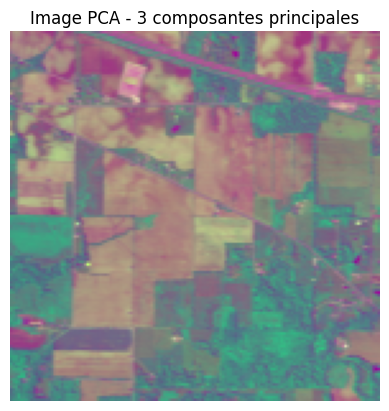

In [4]:
from sklearn.decomposition import PCA

# Reshape pour ACP : (n_pixels, n_bandes)
h, w, b = hyperspectral_data.shape
reshaped_data = hyperspectral_data.reshape(-1, b)

# Normalisation
reshaped_data = reshaped_data.astype('float32')
reshaped_data -= np.min(reshaped_data)
reshaped_data /= np.max(reshaped_data)

# PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(reshaped_data)

# Reshape pour image
pca_image = pca_result.reshape(h, w, 3)

plt.imshow(normalize(pca_image))
plt.title("Image PCA - 3 composantes principales")
plt.axis("off")
plt.show()


In [5]:
print("Variance expliquée (par composante) :", pca.explained_variance_ratio_)


Variance expliquée (par composante) : [0.6849621  0.23530552 0.01496412]


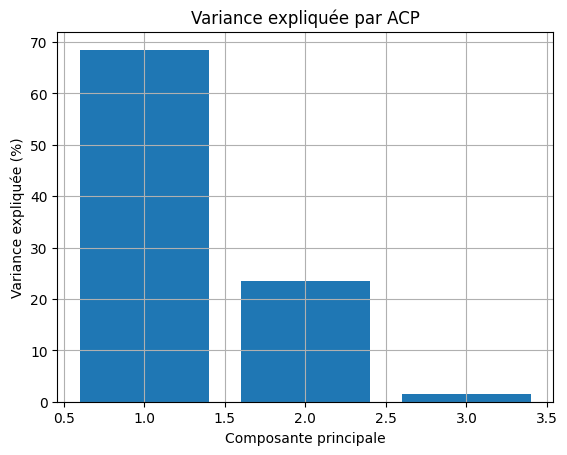

In [6]:
import matplotlib.pyplot as plt

explained = pca.explained_variance_ratio_
plt.bar(range(1, len(explained)+1), explained*100)
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée (%)")
plt.title("Variance expliquée par ACP")
plt.grid(True)
plt.show()


Les deux premières composantes capturent plus de 92% de la variance des données. ✅

La 3e composante n’ajoute pas grand-chose en termes d'information. On pourrait même n’utiliser que les 2 premières pour des visualisations ou de la réduction de dimension.

# 2. Manipulation des images Pavia University

In [10]:
# Charger les données hyperspectrales et la vérité terrain
data = scipy.io.loadmat('PaviaU.mat')
ground_truth = scipy.io.loadmat('PaviaU_gt.mat')

# Extraire l'image hyperspectrale et la vérité terrain
image = data['paviaU']  # dimensions : (610, 340, 103)
gt = ground_truth['paviaU_gt']  # dimensions : (610, 340)

print("Dimensions de l'image :", image.shape)
print("Dimensions de la vérité terrain :", gt.shape)

Dimensions de l'image : (610, 340, 103)
Dimensions de la vérité terrain : (610, 340)


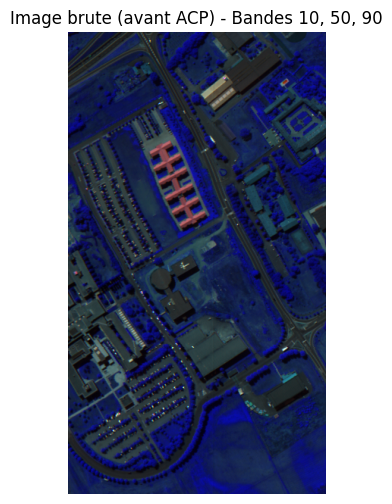

In [12]:
import matplotlib.pyplot as plt

# Choisir 3 bandes spectrales espacées (par exemple : 10, 50, 90)
bandes_rgb = [10, 50, 90]

# Extraire et empiler les 3 bandes
raw_rgb = image[:, :, bandes_rgb]

# Normaliser l'image pour l'affichage
raw_rgb_norm = (raw_rgb - raw_rgb.min()) / (raw_rgb.max() - raw_rgb.min())

# Affichage
plt.figure(figsize=(8, 6))
plt.imshow(raw_rgb_norm)
plt.title("Image brute (avant ACP) - Bandes 10, 50, 90")
plt.axis('off')
plt.show()


In [15]:
# Remodeler l'image en (n_pixels, n_bandes)
reshaped = image.reshape(-1, image.shape[2])

# Normaliser les données (important pour l'ACP)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(reshaped)

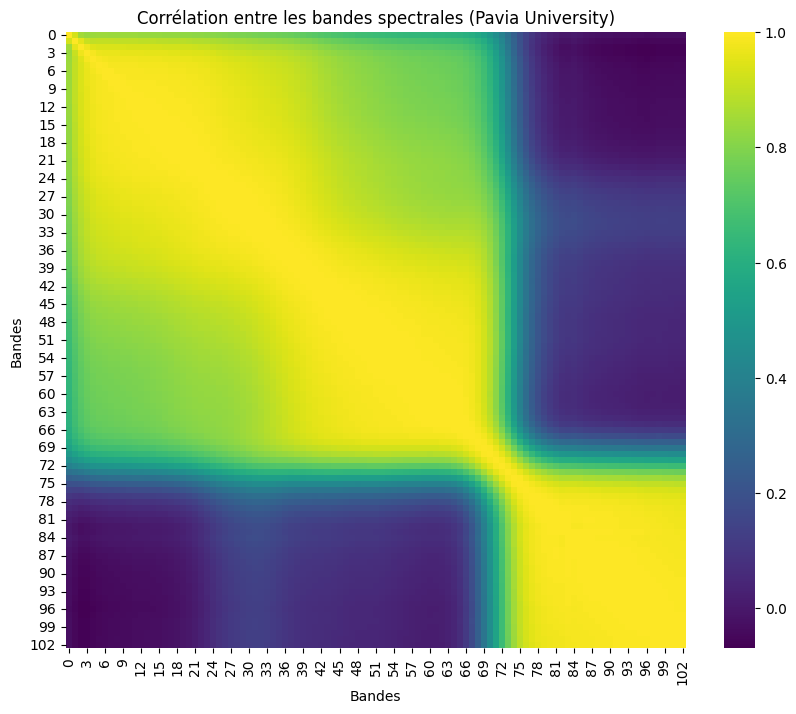

In [14]:
import seaborn as sns

# Calculer la matrice de corrélation entre les bandes
corr_matrix = np.corrcoef(normalized_data.T)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="viridis")
plt.title("Corrélation entre les bandes spectrales (Pavia University)")
plt.xlabel("Bandes")
plt.ylabel("Bandes")
plt.show()


appliquer l'ACP

In [16]:
from sklearn.decomposition import PCA

# Garder les 3 premières composantes principales (pour visualisation RGB)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(normalized_data)

# Remodeler pour revenir à une image RGB
pca_image = pca_result.reshape(image.shape[0], image.shape[1], 3)

# Afficher la variance expliquée par composante
print("Variance expliquée (par composante) :", pca.explained_variance_ratio_)


Variance expliquée (par composante) : [0.64846669 0.28456498 0.05135377]


visualiser l'image après ACP

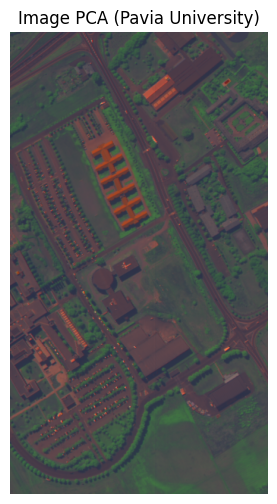

In [17]:
import matplotlib.pyplot as plt

# Normaliser l’image pour un affichage correct entre 0 et 1
pca_norm = (pca_image - np.min(pca_image)) / (np.max(pca_image) - np.min(pca_image))

plt.figure(figsize=(8, 6))
plt.imshow(pca_norm)
plt.title("Image PCA (Pavia University)")
plt.axis('off')
plt.show()


| Dataset           | Taille image        | Nb de bandes | Nb de classes |
|-------------------|---------------------|---------------|----------------|
| Indian Pines      | 145 x 145 x 200     | 200           | 16             |
| Pavia University  | 610 x 340 x 103     | 103           | 9              |
